Ivan KRIVOKUCA

Abdel-malik FOFANA

Theophile TAFFOUREAU

## Dogs 🐶 & Cats 🐱 Images

Données : https://www.kaggle.com/datasets/chetankv/dogs-cats-images

*On suppose que les images sont décompressées* 

In [9]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator


### 1. Chargement de la base d'images

In [10]:
data_dir = "dataset/training_set/"
test_dir = "dataset/test_set/"

class_names=os.listdir(data_dir)
print(class_names)

['cats', 'dogs']


Nombre d'images:  8000


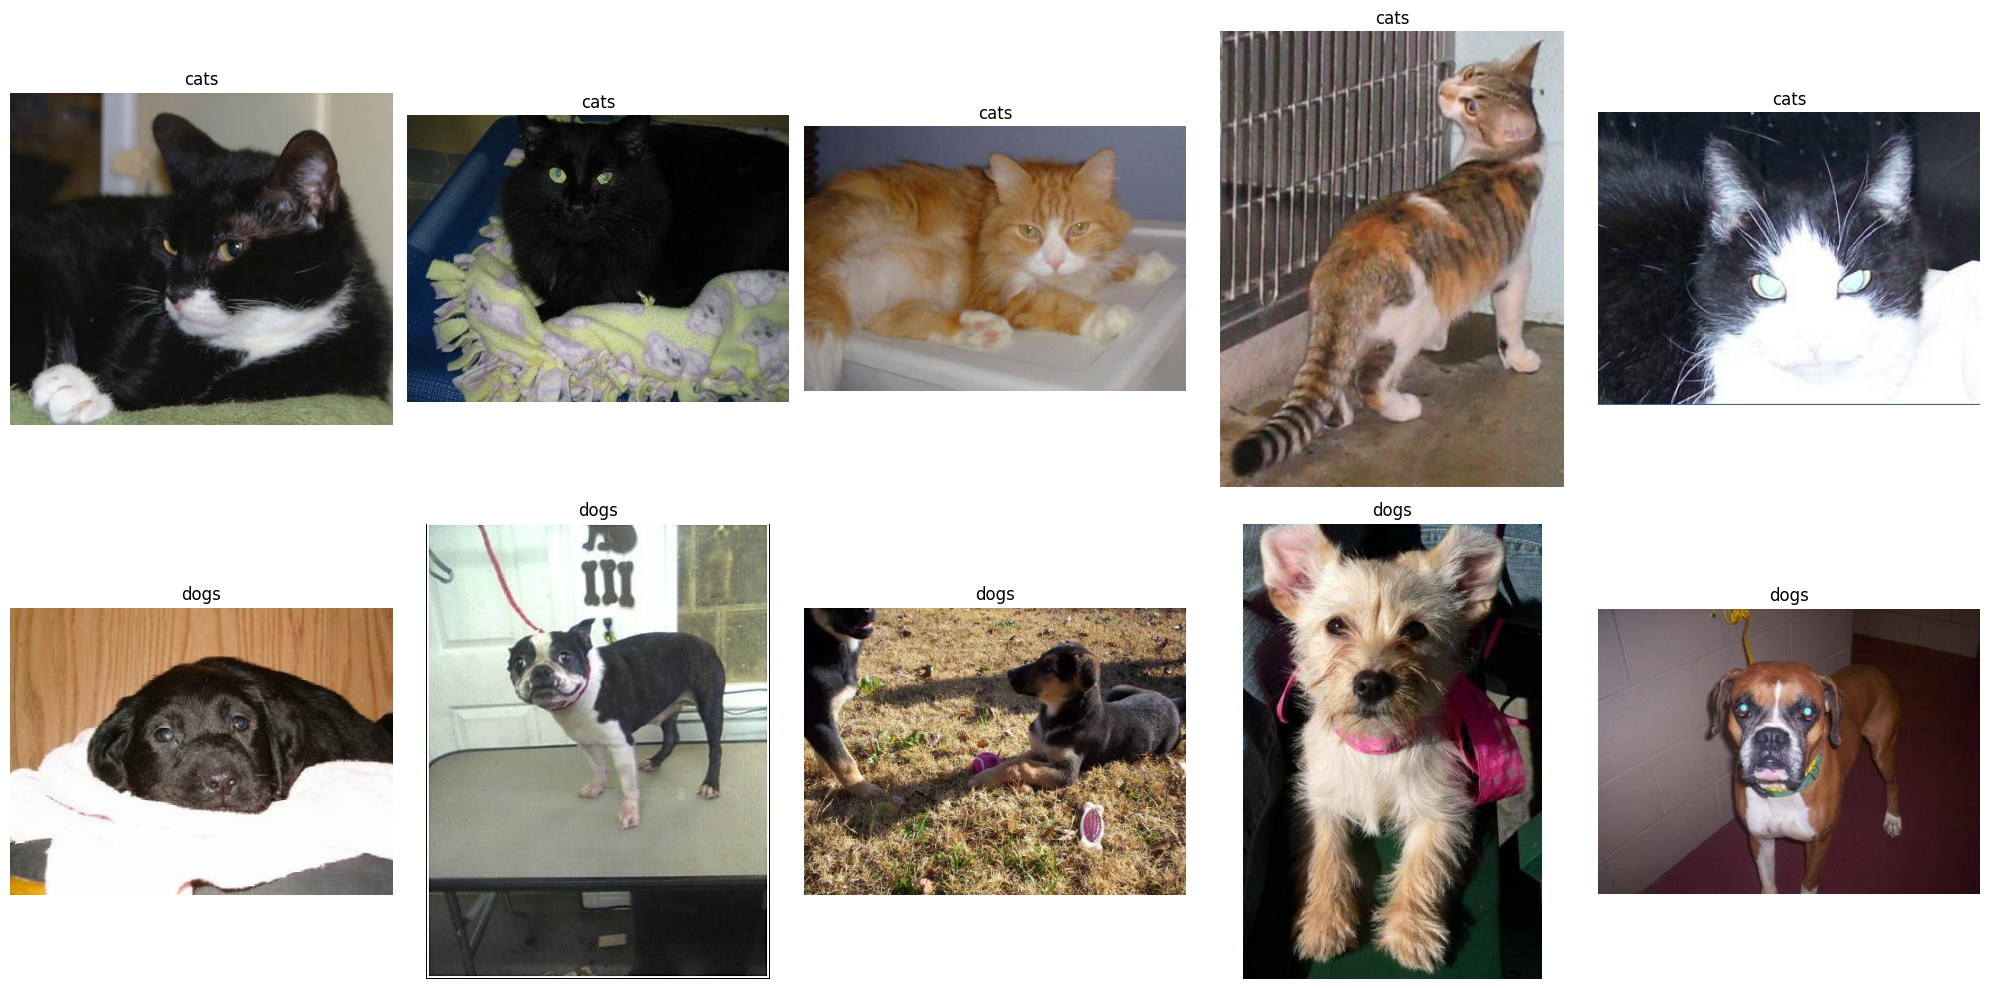

In [11]:
image_paths = []
image_labels = []
images = []

label_images = {class_name: idx for idx, class_name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        image_paths.append(img_path)
        image_labels.append(label_images[class_name])
        img = cv2.imread(img_path)
        images.append(img)

print("Nombre d'images: ", len(image_paths))

# Affichage de quelques images
selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for img_name in random.sample(os.listdir(class_path),5):
        img_path = os.path.join(class_path, img_name)
        selected_images.append(cv2.imread(img_path))
        selected_labels.append(label_images[class_name])

plt.figure(figsize=(20, 10))

for i, (selected_image, selected_label) in enumerate(zip(selected_images, selected_labels)):
    plt.subplot(2, 5, i + 1)
    # Les images lues par cv2 sont en BGR, les convertir en RGB pour l'affichage
    img_rgb = cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    # Utiliser `selected_label` pour obtenir l'étiquette numérique et la convertir en nom de classe
    plt.title(f'{class_names[selected_label]}', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


### 2. Extraction de caractéristiques avec ORB

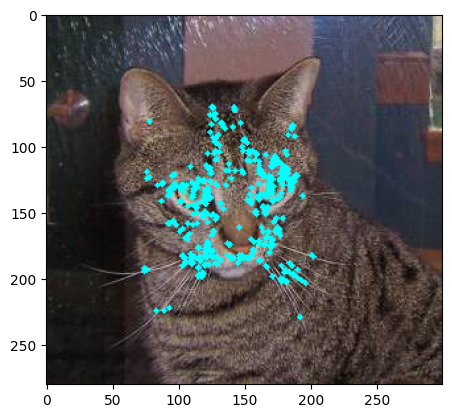

(<matplotlib.image.AxesImage at 0x7fc891e5ffa0>, None)

In [12]:
orb = cv2.ORB_create()

im = cv2.imread("dataset/training_set/cats/cat.1.jpg")

# Conversion de l'image en RGB pour l'affichage avec matplotlib
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Détection des points clés
kp = orb.detect(im, None)

# Calcul des descripteurs
kp, des = orb.compute(im, kp)

# Fonction pour dessiner les points clés
def draw_keypoints(vis, keypoints):
    for kp in keypoints:
        x, y = kp.pt
        cv2.circle(vis, (int(x), int(y)), 2, (0, 255, 255), -1)
    return vis

# Dessin des points clés sur l'image
img_with_kp = draw_keypoints(im_rgb.copy(), kp)

# Affichage de l'image avec les points clés
plt.imshow(img_with_kp), plt.show()

## 3. Classification supervisé

### Kmeans

/home/ivan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


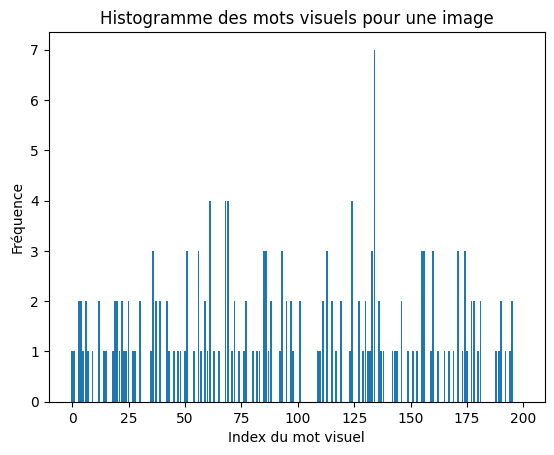

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       820
           1       0.66      0.68      0.67       778

    accuracy                           0.68      1598
   macro avg       0.68      0.68      0.68      1598
weighted avg       0.68      0.68      0.68      1598



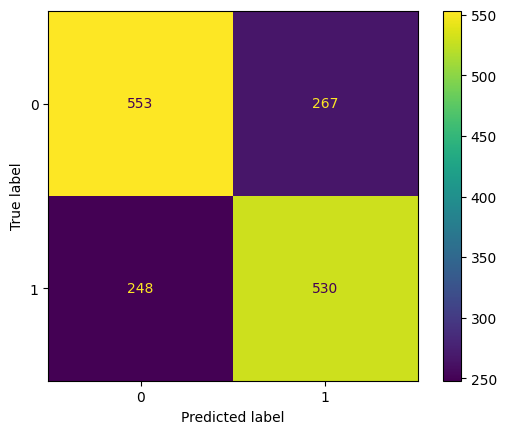

In [15]:
des_list = []  # Liste pour stocker tous les descripteurs
mod_image_labels = []  # Liste pour stocker les étiquettes des images modifiées

# Parcourir toutes les images et extraire les descripteurs ORB
for img_path, label in zip(image_paths, image_labels):
    img = cv2.imread(img_path, 0)
    kp, des = orb.detectAndCompute(img, None)
    if des is not None:
        des_list.append(des)
        mod_image_labels.append(label)

# Regrouper tous les descripteurs dans une grande matrice pour KMeans
all_descriptors = np.vstack(des_list)

# Définir et entraîner KMeans pour créer le vocabulaire
k = 200  # Nombre clusters
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(all_descriptors)

# Bag of Visual Words
features = np.zeros((len(des_list), k), "float32")
for i, des in enumerate(des_list):
    words = kmeans.predict(des)
    for w in words:
        features[i, w] += 1

# Visualisation de Bag of Words
image_histogram = features[0] # on prend la première image

# Histogramme des mots visuels
plt.bar(range(len(image_histogram)), image_histogram)
plt.xlabel('Index du mot visuel')
plt.ylabel('Fréquence')
plt.title('Histogramme des mots visuels pour une image')
plt.show()


# Normalisation des caractéristiques
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, mod_image_labels, test_size=0.2, random_state=42)

# Entraînement du modèle SVC
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

Ce que nous avons réalisé à travers le code ci-dessus :
- Extraction des caractéristiques avec ORB (pour trouver des points d'intérêt uniques sur les images)
- Clustering avec KMeans : nous regroupons les caractéristiques des images en 200 mots (la valeur de k correspond aux clusters)
- Construction du Bag of Visual Words, pour chaque image, nous comptons combien de descripteurs ORB tombent dans chaque cluster KMeans. (c'est le 1er graphique)
- Normalisation des caractéristiques, nécessaire pour l'entraînement
- Entraînement et Évaluation du Modèle SVM
- Matrice de Confusion pour évaluer les performances de ce qu'on a fait

**Analyse des résultats**

Pour rappel, les étiquettes :
- 0 : chat
- 1 : chien

Sans avoir énormément touché aux paramètres (ce qui sera fait plus tard avec l'ajout d'autres techniques comme le CNN), on remarque qu'on a pour les chiens 66 % de prédictions pour cette classe (c'est-à-dire que le modèle prédit cette image appartenant à la classe chien 66 % du temps),
69 % pour les chats.

On est à 0.68 d'accuracy (précision) sur les deux modèles, ce qui est assez satifisant.

Avec la matrice de confusion :
- Classe 0 (chat) : on remarque que 553 images ont été bien classées alors que 267 images l'ont été incorrectement.
- Classe 1 (chien) : 530 bien classées, 248 fausses.

### CNN (classification binaire)

In [6]:
# Préparation des données pour le CNN
train_datagen = ImageDataGenerator(rescale=1./255, # normalisation
                                   rotation_range=20, # degré de rotation (meilleur résultat)
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True, # effet miroir
                                   fill_mode='nearest') # nearest est la méthode d'interpolation

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(256,  256),
    batch_size=32,
    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,  256),
    batch_size=32,
    class_mode='binary',
	shuffle=False)  # On s'assure que les données ne sont pas mélangées = meilleur résultat

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
# Définition du modèle CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

2024-02-25 14:14:58.613088: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-25 14:14:58.686271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-25 14:14:58.686473: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
model.fit(train_generator, epochs=30, validation_data=test_generator)

Epoch 1/30


2024-02-25 14:14:59.963161: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-25 14:15:00.062728: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-25 14:15:00.602587: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-25 14:15:01.381199: I external/local_xla/xla/service/service.cc:168] XLA service 0x7febbcc26420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-25 14:15:01.381220: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-02-25 14:15:01.385011: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708866901.455789  211676 devic

250/250 [==============================] - 63s 231ms/step - loss: 0.7036 - accuracy: 0.5598 - val_loss: 0.6622 - val_accuracy: 0.5990
Epoch 2/30
250/250 [==============================] - 59s 236ms/step - loss: 0.6744 - accuracy: 0.5778 - val_loss: 0.6819 - val_accuracy: 0.5915
Epoch 3/30
250/250 [==============================] - 59s 235ms/step - loss: 0.6610 - accuracy: 0.6151 - val_loss: 0.6685 - val_accuracy: 0.6080
Epoch 4/30
250/250 [==============================] - 59s 234ms/step - loss: 0.6241 - accuracy: 0.6607 - val_loss: 0.5774 - val_accuracy: 0.7095
Epoch 5/30
250/250 [==============================] - 58s 232ms/step - loss: 0.5934 - accuracy: 0.6870 - val_loss: 0.5486 - val_accuracy: 0.7290
Epoch 6/30
250/250 [==============================] - 58s 232ms/step - loss: 0.5701 - accuracy: 0.6950 - val_loss: 0.5405 - val_accuracy: 0.7280
Epoch 7/30
250/250 [==============================] - 58s 230ms/step - loss: 0.5578 - accuracy: 0.7179 - val_loss: 0.5494 - val_accuracy: 0.7

63/63 [==============================] - 2s 30ms/step
Accuracy: 0.8275


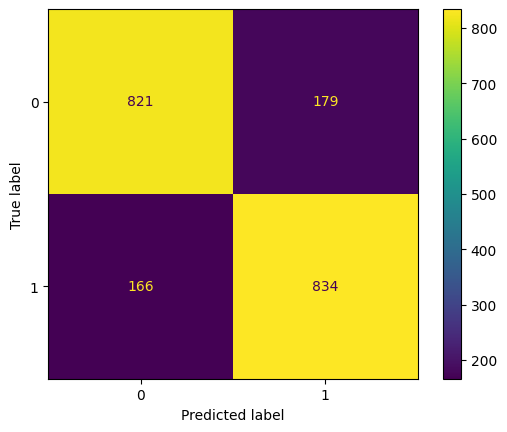

In [9]:
y_pred = model.predict(test_generator)
# Convertir les prédictions binaires en classes
y_pred_classes = [1 if y >  0.5 else  0 for y in y_pred]

# Obtenir les vraies classes
y_true = test_generator.classes

# Calculer Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy:", accuracy)


# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

Les points clés de cette approche sont :
- Le modèle a été entraîné sur un ensemble de données augmenté, ayant subi des transformations telles que la rotation, le zoom, et le retournement, dans le but d'améliorer la capacité de généralisation du modèle.
- Le modèle CNN est composé de couches, dont celle d'activation "sigmoid" pour la classification binaire

Voici la matrice de confusion obtenue :

821 et 834 images ont été correctement classées comme chats et chiens, respectivement.

179 et 166 images ont été mal classées pour chacune des catégories, respectivement.


Cela démontre que l'approche basée sur le CNN est "meilleure" pour cette tâche de classification. Néanmoins, il est important de noter que le temps nécessaire pour obtenir ces résultats n'est pas négligeable : environ 1 minute pour KMeans contre environ 20 minutes pour le CNN.

### CNN (classification categorical + changements de paramètres)

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# class_mode à 'categorical' pour une classification catégorielle
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Définition du modèle CNN pour une classification catégorielle
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
	Conv2D(256, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax') # 2 classes et activation softmax
])

model.summary()

# Compilation du modèle pour une classification catégorielle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=40, validation_data=test_generator)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                      

2024-02-25 17:47:02.655408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-25 17:47:02.680033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-25 17:47:02.680188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/40


2024-02-25 17:47:04.216390: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-25 17:47:04.287177: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-25 17:47:05.332964: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-25 17:47:05.816986: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc758c0b490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-25 17:47:05.817006: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-02-25 17:47:05.820813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708879625.886833  756196 devic

125/125 [==============================] - 59s 406ms/step - loss: 0.8392 - accuracy: 0.5005 - val_loss: 0.6840 - val_accuracy: 0.5455
Epoch 2/40
125/125 [==============================] - 52s 413ms/step - loss: 0.6772 - accuracy: 0.5511 - val_loss: 0.6581 - val_accuracy: 0.5830
Epoch 3/40
125/125 [==============================] - 52s 412ms/step - loss: 0.6688 - accuracy: 0.5700 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 4/40
125/125 [==============================] - 52s 416ms/step - loss: 0.6942 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 5/40
125/125 [==============================] - 52s 417ms/step - loss: 0.6704 - accuracy: 0.5644 - val_loss: 0.6174 - val_accuracy: 0.6410
Epoch 6/40
125/125 [==============================] - 52s 413ms/step - loss: 0.6597 - accuracy: 0.5810 - val_loss: 0.6059 - val_accuracy: 0.6615
Epoch 7/40
125/125 [==============================] - 52s 412ms/step - loss: 0.6330 - accuracy: 0.6275 - val_loss: 0.5937 - val_accuracy: 0.6

32/32 [==============================] - 3s 76ms/step
Accuracy: 0.859


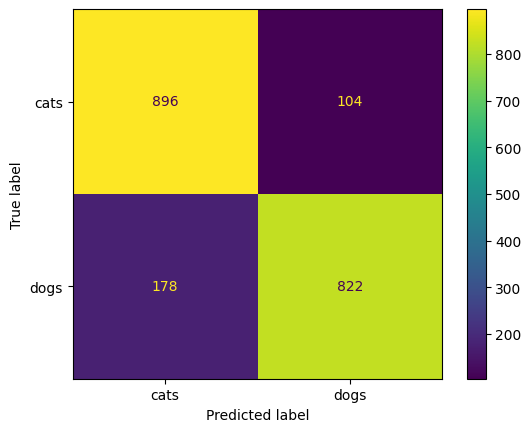

2/2 [==============================] - 1s 8ms/step


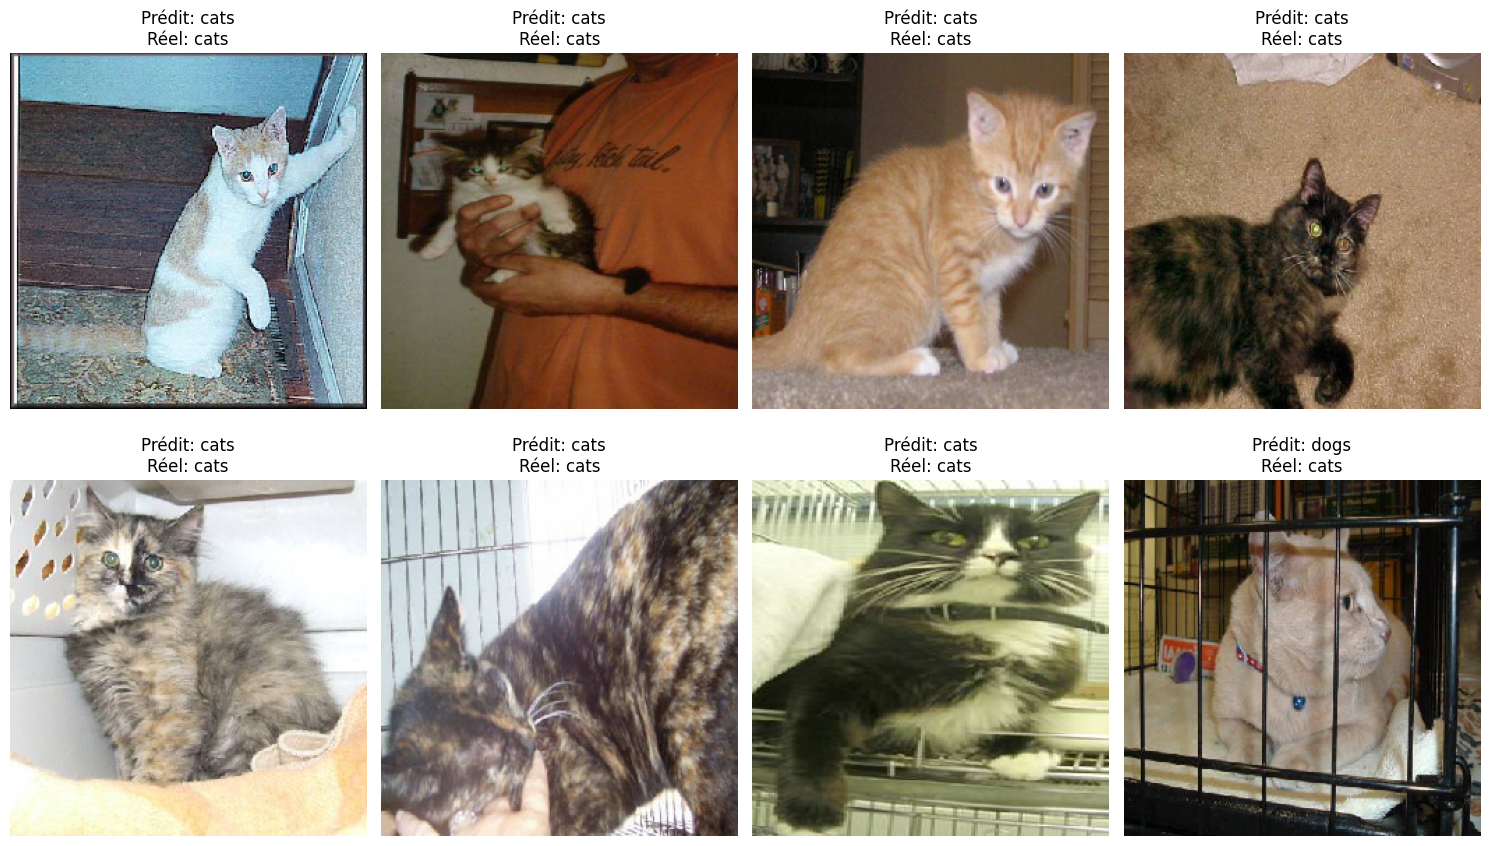

In [5]:
# On s'assure de reset le générateur de test avant de faire des prédictions
test_generator.reset()

# Prédiction
y_pred = model.predict(test_generator)

# Convertir les prédictions en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtenir les vraies classes
y_true = test_generator.classes

accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_true, y_pred_classes)
labels = list(test_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

# Affichage de quelques images avec les étiquettes prédites et réelles
x_batch, y_batch = next(test_generator)  # Charger un lot

# Faire des prédictions sur ce lot
predictions_batch = model.predict(x_batch)
predictions_classes_batch = np.argmax(predictions_batch, axis=1)

# Afficher les images avec les étiquettes prédites et réelles pour un sous-ensemble du lot
plt.figure(figsize=(15, 9))
num_images = 8
for i in range(num_images):
    plt.subplot(2, 4, i+1)
    img = x_batch[i]
    plt.imshow(img)
    true_index = np.argmax(y_batch[i])
    plt.title(f"Prédit: {labels[predictions_classes_batch[i]]}\nRéel: {labels[true_index]}", fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

Nous avons comparé les configurations binaire et catégorielle du modèle CNN. De plus, nous avons tenté de modifier les paramètres et hyperparamètres des fonctions (augmenter le nombre de couches, ajuster le batch size, etc.)

Nous avons observé qu'un nombre d'épochs supérieur à 30 n'est pas forcément nécessaire ; au-delà, la précision (accuracy) tend à stagner. De plus, il n'y a pas de différence significative entre les modes binaire et catégoriel dans notre modèle, ce qui est logique étant donné que nos données se répartissent exclusivement entre chats et chiens

On voit qu'on a une meilleur matrice de confusion / accuracy via nos changements de paramètres

Pour conclure, nous avons voulu tester notre modèle sur un petit échantillon pour voir comment il prédit les images qui lui sont soumises, d'après la précision obtenue, les résultats semblent plutôt cohérents